In [1]:
import os
import sys
import pandas as pd 

sys.path.append("../python")

import matplotlib.pyplot as plt
import numpy as np
from gurobipy import *
import math

In [2]:
X = pd.read_csv('../heuristic/data/X.csv')
Y = pd.read_csv('../heuristic/data/Y.csv')
Z = pd.read_csv('../heuristic/data/Z.csv')

#Créer un nouveau dataframe qui contient al différence de X et Y 
df_to_cluster = pd.DataFrame()
for i in range(len(Y.columns.tolist())):
    df_to_cluster['x_'+ str(i)+ '-y_'+ str(i)] = X.iloc[:,i] - Y.iloc[:,i]

df_to_cluster = df_to_cluster.drop(columns = df_to_cluster.columns[0])

In [3]:
from sklearn.cluster import KMeans
K = 3
kmeans = KMeans(n_clusters=K, n_init=1, init='k-means++').fit(df_to_cluster)

In [4]:
label = kmeans.labels_

In [57]:
#On ajoute les occurences dans chaque cluster
cluster_0 = np.empty((0, df_to_cluster.shape[1]))
cluster_1 = np.empty((0, df_to_cluster.shape[1]))
cluster_2 = np.empty((0, df_to_cluster.shape[1]))

label = kmeans.labels_

for i in range(len(label)): 
    if label[i] == 0:
        cluster_0 = np.vstack([cluster_0, np.array(df_to_cluster.iloc[i,:])])
    elif label[i] == 1:   
        cluster_1 = np.vstack([cluster_1,  np.array(df_to_cluster.iloc[i,:])])
    elif label[i] == 2:   
        cluster_2 = np.vstack([cluster_2,  np.array(df_to_cluster.iloc[i,:])])

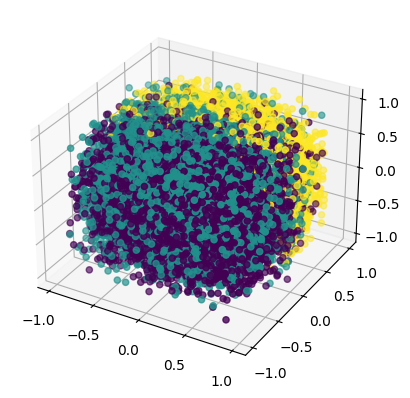

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# the points color depends on their label
ax.scatter(df_to_cluster.iloc[:, 4], df_to_cluster.iloc[:, 5], df_to_cluster.iloc[:, 6], c=kmeans.labels_)
plt.show()

In [74]:
# Instanciation du modèle
m = Model("HeuristicV0")
PRECISION = 0.001

#Nombre de features
N_CRITERIA = len(df_to_cluster.iloc[0,:])

#Nombre de segment/breakpoints dans toutes les fonctions de score, possible de l'adapter pour chaque feature 
L = 5
#Nombre d'occurence dans le dataset/produits traités 
N_COMPARAISON = [len(cluster_0),len(cluster_1),len(cluster_2)]

#Majorant contrainte 
M=4

#à définir clairement : 

criteria = [[[(m.addVar(name=f"u_{j}{l}{k}")) for k in range(K)] for l in range(L+1)]for j in range(N_CRITERIA)]
sigma_Xplus = [[],[],[]]
sigma_Xminus = [[],[],[]]

for k in range(K): 
    for i in range(N_COMPARAISON[k]):
        sigma_Xplus[k].append((m.addVar(name=f"sigma+{i}{k}")))
        sigma_Xminus[k].append((m.addVar(name=f"sigma-{i}{k}")))

#hyperparamètre pour le modèle
epsilon = PRECISION
# maj du modèle
m.update()

#print(r"120", criteria[1][2][0])
#print(r"230", criteria[2][3][0])
#print(r"140", criteria[1][4][0])



#récupère les minimum et maximum de chaque feature 
#mins = (min(X_re.min(axis=0), Y_re.min(axis=0))).any()
#maxs = (max(X_re.max(axis=0), Y_re.max(axis=0))).any()

mins= df_to_cluster.values.min(axis=0)
maxs= df_to_cluster.values.max(axis=0)

def segment(i, j, X):
    x = X[i][j]
    #floor permet de faire l'arrondi 
    #donne un chiffre entre 0 et L (ici 5) qui donne l'appartenance à l'un des 6 segment possible 
    #X[i] correspond à une occurence d'un produit traité 
    #j correspond à l'indice de feature 
    #correspond au commentaire de la question 2
    return math.floor(L * (x - mins[j]) / (maxs[j] - mins[j]))

#cette fonction précédente permettra a priori de trouver le l de la fonction suivante

#l correspond au tronçon sur lequel est la valeur 
#retourne l'abscisse de gauche ? du tronçon l 
#appelé xik dans question 3
def x_seg(j, seg):
    return mins[j] + seg * (maxs[j] - mins[j]) / L

#calcule la valeur si(xij)
#cad le score partiel pour un feature donné 
# ?? on obtient le score à partir d'une forme ressemblant au développement limité autour de la valeur de la feature sur le tronçon

def u(i,j,k,X,eval : bool = False):
    get_val = (lambda v: v.X) if eval else (lambda v: v)
    x = X[i][j]
    #segm pour le numéro de tronçon
    
    segm = segment(i, j, X)
    #print(r"segm",segm)
    x_segm = x_seg(j, segm)
    #print(r"x_segm", x_segm)
    x_segm_1 = x_seg(j, segm +1)
    #print(r"x_segm_1", x_segm_1)


    if x == maxs[j]:
        return get_val(criteria[j][L][k]) 
    
    S=0
    S = get_val(criteria[j][segm][k])
    slope = (x - x_segm)/(x_segm_1 - x_segm)
    width = get_val(criteria[j][segm+1][k]) - get_val(criteria[j][segm][k])
    S =+ slope*width

    return S


#définissons la somme des fonctions de score pour un produit (de rang i)
def s(i, X, k, eval : bool = False):
    if not eval : 
        return quicksum(u(i,j,k,X,False) for j in range(N_CRITERIA))
    else : 
        return sum(u(i,j,k,X,False) for j in range(N_CRITERIA))



# Ajout des contraintes

#Documentation Gurobi propre
    
# contraintes de préférence des universités

for i in range(N_COMPARAISON[0]) :
    m.addConstr(s(i, cluster_0, 0, False) - s(i, cluster_0, 1, False) - sigma_Xplus[0][i]+ sigma_Xminus[0][i] >= epsilon)
    m.addConstr(s(i, cluster_0, 0, False) - s(i, cluster_0, 2, False) - sigma_Xplus[0][i]+ sigma_Xminus[0][i] >= epsilon)

for i in range(N_COMPARAISON[1]) :
    m.addConstr(s(i, cluster_1, 1, False) - (s(i, cluster_1, 0, False) - sigma_Xplus[1][i]+ sigma_Xminus[1][i]) >= epsilon)
    m.addConstr(s(i, cluster_1, 1, False) - (s(i, cluster_1, 2, False) - sigma_Xplus[1][i]+ sigma_Xminus[1][i]) >= epsilon)

for i in range(N_COMPARAISON[2]) :
    m.addConstr(s(i, cluster_2, 2, False) - (s(i, cluster_2, 1, False) - sigma_Xplus[2][i]+ sigma_Xminus[2][i]) >= epsilon)
    m.addConstr(s(i, cluster_2, 2, False) - (s(i, cluster_2, 0, False) - sigma_Xplus[2][i]+ sigma_Xminus[2][i]) >= epsilon)
        

# Constraint for sigma_Xminus
for k in range(K):
    for i in range(N_COMPARAISON[k]):
        m.addConstr(sigma_Xminus[k][i] >= 0)

# Constraint for sigma_Xplus
for k in range(K):
    for i in range(N_COMPARAISON[k]):
        m.addConstr(sigma_Xplus[k][i] >= 0)


#for sig in sigma_Xminus + sigma_Xplus + sigma_Yminus + sigma_Yplus:
#    m.addConstr(sig >= 0)

# contrainte 3
for k in range(K) :
    for j in range(N_CRITERIA):
        for l in range(L):
            m.addConstr(criteria[j][l+1][k] - criteria[j][l][k] >= epsilon)


# contrainte 4
for k in range(K):
        m.addConstr(quicksum(criteria[j][L][k] for j in range(N_CRITERIA)) ==1)
    
#m.addConstr(s(i, X, k, False) == 1)

# contrainte 5
for k in range(K):
    for j in range(N_CRITERIA):
        #ajustement arbitraire avec 2222 car u() traite toujours des matrices
        mins_ada = np.vstack([np.array([ 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]), mins])
        
        print(mins_ada)
        #mins correspond aux plus petites valeurs possibles pour chaque critère
        m.addConstr(u(1, j,k, mins_ada, False) == 0)


        
# Flatten the lists of lists into a single list
sigma_Xplus_flat = [var for sublist in sigma_Xplus for var in sublist]
sigma_Xminus_flat = [var for sublist in sigma_Xminus for var in sublist]

# Objective function
m.setObjective(sum(sigma_Xplus_flat) + sum(sigma_Xminus_flat), GRB.MINIMIZE)


# Fonction Objectif
#m.setObjective(sum(sigma_Xplus) + sum(sigma_Xminus) + sum(sigma_Yminus) + sum(sigma_Yplus), GRB.MINIMIZE)         
# Paramétrage (mode mute)
m.Params.Presolve = 0
# Résolution du PL
m.optimize()
#print("La solution optimale est (v0, v1) = {} avec pour objectif z = {}".format((v0.x, v1.x), m.objVal))
for k in range(K):
    for j in range(N_CRITERIA):
        for l in range(L):
            print()
            print(criteria[j][l][k])